# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

!unzip -q data.zip

--2023-12-10 01:06:11--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-10 01:06:11--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   593KB/s    in 34s     

2023-12-10 01:06:47 (1.08 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [58]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [59]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps' # Hi, Apple Silicon
else:
    device = 'cpu'

device

'mps'

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [60]:
def get_xml_data(
    image_name: str, 
    root: Path,
    class_dict: dict, 
    xml_prefix='/xmls/'
):
    filename = image_name.split('/')[-1].split('.')[0]

    tree = ET.parse(str(root) + xml_prefix + filename + '.xml')
    tree_root = tree.getroot()
    
    bounding_boxes = []
    
    for member in tree_root.findall('object'):
        # you need: xmin ymin xmax ymax, class in dict
        x_min = int(member.find('bndbox').find('xmin').text)
        y_min = int(member.find('bndbox').find('ymin').text)
        x_max = int(member.find('bndbox').find('xmax').text)
        y_max = int(member.find('bndbox').find('ymax').text)
        
        class_name = member.find('name').text
        class_id = class_dict[class_name]

        res = [x_min, y_min, x_max, y_max, class_id]

        bounding_boxes.append(res)

    return bounding_boxes

In [61]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root='dataset', train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f'No data at `{root}`'

        self.filenames = np.array(glob.glob(root + '/images/*'))
        with open(str(self.root) + '/class_dict', 'r') as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = np.array(Image.open(filename).convert('RGB'))
        bounding_boxes = get_xml_data(filename, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bounding_boxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [62]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format='pascal_voc', min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format='pascal_voc', min_visibility=0.5),
)

In [63]:
train_dataset = PascalDataset(root='./data/', transform=train_transform, train=True)
test_dataset = PascalDataset(root='./data/', transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [64]:
def visualize(
        images, 
        bounding_boxes, 
        class_dict
):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        nrows=2, 
        ncols=len(images) // 2 + len(images) % 2, 
        figsize=(10, 10), 
        dpi=100
    )
    
    for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)

        if i >= len(images):
            break

        ax.imshow(images[i].permute(1, 2, 0).numpy() * std  + mean)

        for bounding_box in bounding_boxes[i]:
            x_min, y_min, x_max, y_max, class_index = bounding_box
            
            class_name = class_dict[class_index]
            
            xy = (x_min, y_min)
            width = x_max - x_min
            height = y_max - y_min
            
            rect = Rectangle(xy, width, height, linewidth=2, edgecolor='r', facecolor='none')
            
            ax.add_patch(rect)
            ax.text(x_min, y_min, str(class_name), color='r', fontsize=12, bbox=dict(facecolor='white', alpha=1))
    
    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


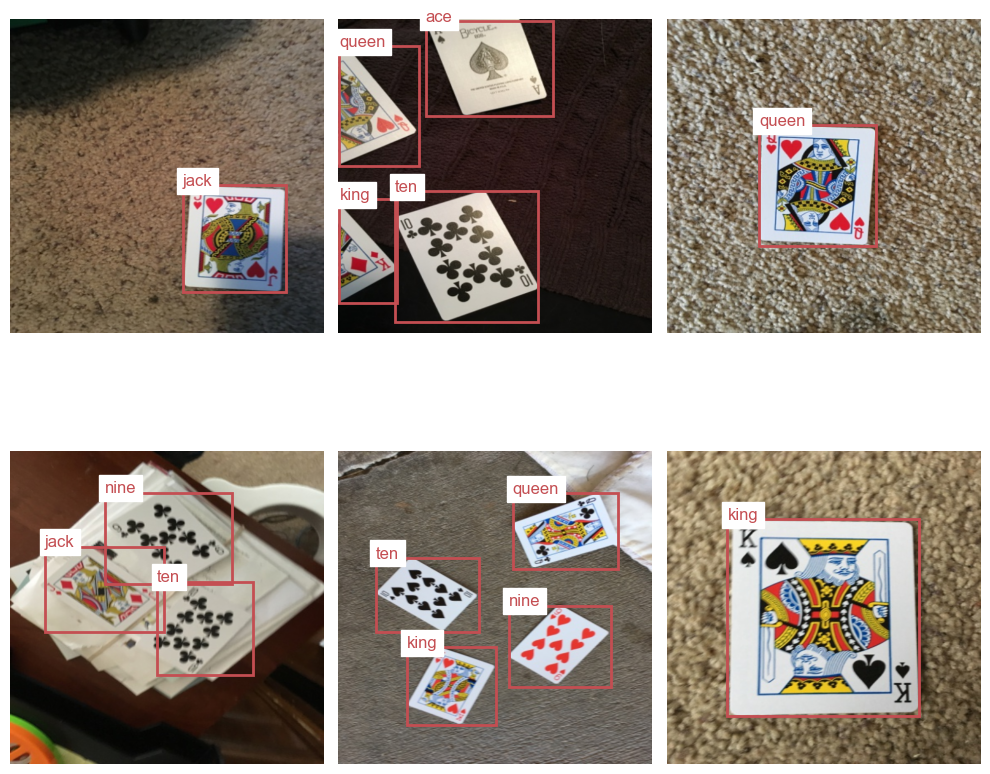

In [65]:
out = [train_dataset[i] for i in range(6)]
images = [o['image'] for o in out]
bounding_boxes = [o['bboxes'] for o in out]

visualize(images, bounding_boxes, train_dataset.class_dict_inv)

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16. 

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [66]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b['image'], b['bboxes']) for b in batch])))

    imgs = torch.stack(imgs)
    batch_size, _, height, width = imgs.shape

    target = imgs.new_zeros(batch_size, 6, height // downsample, width // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        x_min, y_min, x_max, y_max, classes = map(
            torch.squeeze, 
            torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        box_width = (x_max - x_min) / width
        box_height = (y_max - y_min) / height

        # Посчитайте координаты центра и сдвиги
        cell_x = (x_max + x_min) / 2 
        cell_y = (y_max + y_min) / 2 
        cell_x_index = (cell_x // downsample).to(torch.long)
        cell_y_index = (cell_y // downsample).to(torch.long)

        cell_x_box = (cell_x - cell_x_index * downsample) / downsample
        cell_y_box = (cell_y - cell_y_index * downsample) / downsample

        target[i, :, cell_y_index, cell_x_index] = torch.stack(
            [cell_x_box, cell_y_box, box_width, box_height, torch.ones_like(cell_x_box), classes]
        )

    return {
        'image': imgs, 
        'target': target
    }

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

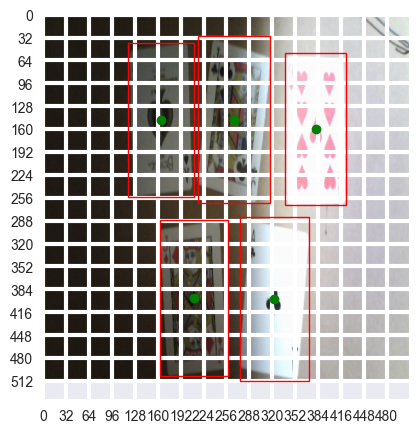

In [67]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_dataset[i]['image'].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_dataset[i]['bboxes'])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which='major', axis='both', linestyle='-', linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color='red'))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color='green', marker='o')

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему? 

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами. 

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [68]:
def decode_prediction(prediction, upsample=32, threshold=0.7):
    batch_size, channels, height, width = prediction.shape
    img_width, img_height = width * upsample, height * upsample
    
    result = []
    
    for i in range(batch_size):
        bounding_boxes = []
        
        for j in range(width):
            for k in range(height):
                if channels == 6:
                    cell_x_box, cell_y_box, box_width, box_height, confidence, classes = prediction[i,: , j, k]
                else:
                    cell_x_box, cell_y_box, box_width, box_height, confidence = prediction[i,:5 , j, k]
                    classes = torch.argmax(torch.tensor(prediction[i, 5:, j, k]))
                    
                if confidence > threshold:
                    cell_x = (cell_y_box + k) * upsample
                    cell_y = (cell_x_box + j) * upsample
                    
                    x_dif = img_width * box_width
                    y_dif = img_height * box_height
                    
                    x_max = (cell_x * 2 + x_dif) // 2
                    x_min = 2 * cell_x - x_max
                    
                    y_max = (cell_y * 2 + y_dif) // 2
                    y_min = 2 * cell_y - y_max
                    
                    bounding_boxes.append(
                        [x_min.item(), y_min.item(), x_max.item(), y_max.item(), classes.item()]
                    )
                    
        result.append(bounding_boxes)
        
    return result

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [69]:
classes_num = 6

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet_blocks = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        self.custom_blocks = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 5 + classes_num, kernel_size=3, padding=1)
        )

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, img):
        out = self.resnet_blocks(img)
        out = self.custom_blocks(out)
        out = self.sigmoid(out)
        return out

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [86]:
def special_loss(prediction, target, check=False):
    object_mask = target[:, 4, :, :] > 0

    def calculate_loss(target, prediction, loss_function):
        return loss_function(
            target.masked_select(object_mask.unsqueeze(1)),
            prediction[:, 0:2, :, :].masked_select(object_mask.unsqueeze(1))
        )

    mse_loss = nn.MSELoss(reduction='sum')
    cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum')
    bce_loss = nn.BCELoss(reduction ='sum')

    localization_target = target[:, 0:2, :, :]
    localization_prediction = prediction[:, 0:2, :, :]
    localization_loss = calculate_loss(localization_target, localization_prediction, mse_loss)

    box_target = target[:, 2:4, :, :]
    box_prediction = prediction[:, 2:4, :, :]
    box_loss = calculate_loss(box_target, box_prediction, mse_loss)

    target_masked = torch.where(
        object_mask,
        target[:, 5, :, :],
        torch.zeros_like(target[:, 5, :, :])
    )
    prediction_masked = torch.where(
        object_mask.unsqueeze(1),
        prediction[:, 5:, :, :],
        torch.zeros_like(prediction[:, 5:, :, :])
    )
    classification_loss = cross_entropy_loss(prediction_masked, target_masked.long())

    target_masked = torch.where(
        object_mask,
        target[:, 4, :, :],
        torch.zeros_like(target[:, 4, :, :])
    )
    prediction_masked = torch.where(
        object_mask,
        prediction[:, 4, :, :],
        torch.zeros_like(prediction[:, 4, :, :])
    )
    confidence_loss = bce_loss(prediction_masked, target_masked)

    inversed_object_mask = ~object_mask

    target_masked = torch.where(
        inversed_object_mask,
        target[:, 4, :, :],
        torch.zeros_like(target[:, 4, :, :])
    )
    prediction_masked = torch.where(
        inversed_object_mask,
        prediction[:, 4, :, :],
        torch.zeros_like(prediction[:, 4, :, :])
    )
    confidence_loss += 0.1 * bce_loss(prediction_masked, target_masked)

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [87]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(
    torch.zeros((10, 8, 16, 16)), 
    torch.ones((10, 8, 16, 16)), 
    check=True, 
) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [88]:
loader = torch.utils.data.DataLoader(train_dataset, 10, collate_fn=collate_fn)

In [89]:
torch.manual_seed(21)
EPOCHS = 15  # Harry Potter 20, Cards 15
model = Detector().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    
    for batch in pbar:
        images = batch['image'].to(device)
        targets = batch['target'].to(device)

        # делаем предик
        predictions = model(images)

        # считаем лосс
        loss = special_loss(predictions, targets)
        epoch_losses.append(loss.item())

        # считаем градиенты бэкпропом
        loss.backward()

        # делаем шаг градиентного спуска
        optimizer.step()

        # подчищаем градиенты, чтобы они не суммировались на следующих итерациях
        optimizer.zero_grad()

    print(f'Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 4598.876;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 4544.025;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 4535.804;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 4531.964;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 4530.517;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 4529.677;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 4529.169;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 4527.582;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 4526.887;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 4525.776;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 4525.220;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 4523.958;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 4524.169;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 4524.214;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 4524.132;


Запустим обученный детектор на тестовых изображениях:

In [90]:
test_loader = torch.utils.data.DataLoader(test_dataset, 6, collate_fn=collate_fn)
iterator = iter(test_loader)
batch = next(iterator)

/var/folders/sz/l2xvmpg1257f7qh94tplcknx7ycbqf/T/ipykernel_89059/2147317756.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.argmax(torch.tensor(prediction[i, 5:, j, k]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


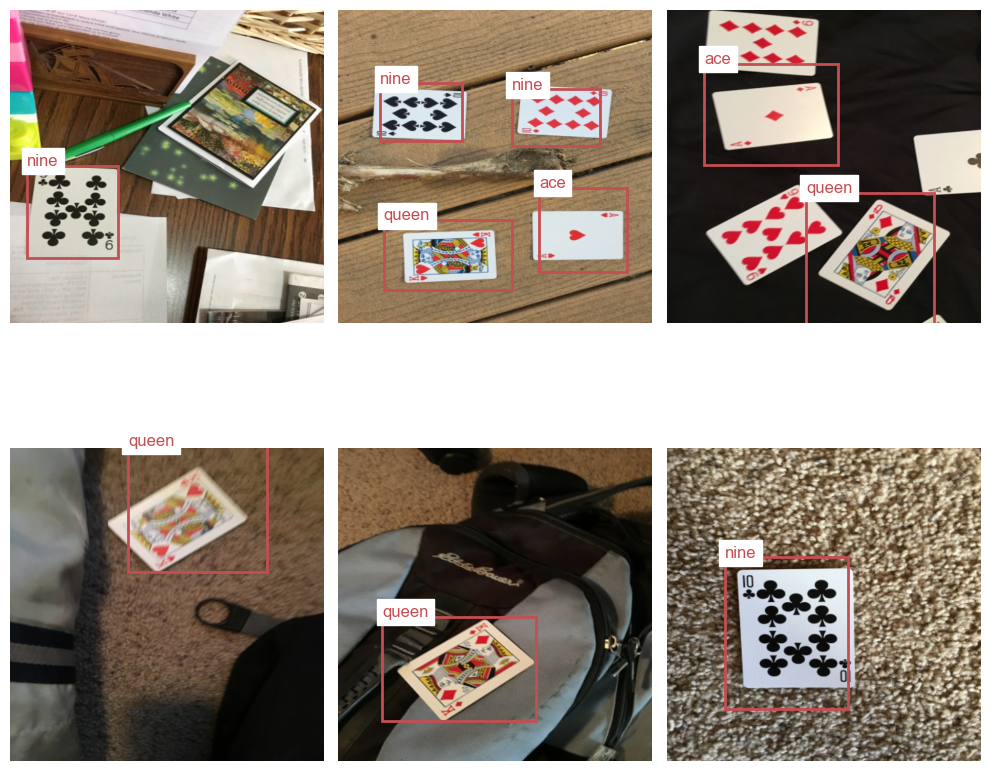

In [91]:
result = model(batch['image'].to(device))
visualize(
    images=batch['image'], 
    bounding_boxes=decode_prediction(
        prediction=result, 
        upsample=32,
        threshold=0.8
    ),
    class_dict=test_loader.dataset.class_dict_inv
)

/var/folders/sz/l2xvmpg1257f7qh94tplcknx7ycbqf/T/ipykernel_89059/2147317756.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes = torch.argmax(torch.tensor(prediction[i, 5:, j, k]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


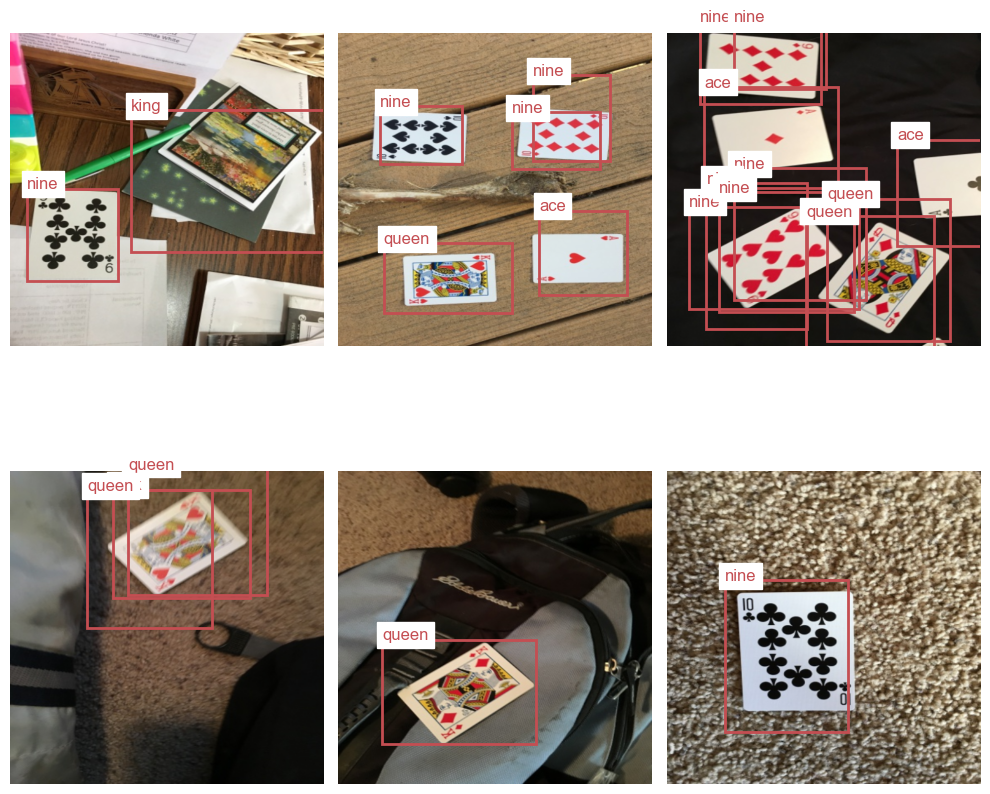

In [92]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
visualize(
    images=batch['image'],
    bounding_boxes=decode_prediction(
        prediction=result,
        upsample=32,
        threshold=0.1 # при 0.1 все очень плохо, очень много bbox'ов
    ),
    class_dict=test_loader.dataset.class_dict_inv
)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [1]:
# Делаем папочки
!rm -rf runs
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [2]:
def annotation2txt(bounding_boxes, image_width, image_height):
    text = []
    
    for bounding_box in bounding_boxes:
        x_min, y_min, x_max, y_max, class_id = bounding_box
        
        text.append(
            f'{class_id} {(x_min + x_max) * 0.5 / image_width} {(y_min + y_max) * 0.5 / image_height} '
            f'{(x_max - x_min) / image_width} {(y_max - y_min) / image_height}'
        )
        
    return text

In [11]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_dataset)):
    result = train_dataset.__get_raw_item__(i)

    shutil.copyfile(
        result[0], './train/images/' + result[0].split('/')[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        './train/labels/' + result[0].split('/')[-1].split('.')[0] + '.txt',
        'w',
        encoding='utf8',
    ) as f:
        f.write('\n'.join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_dataset)):
    result = test_dataset.__get_raw_item__(i)

    shutil.copyfile(
        result[0], './valid/images/' + result[0].split('/')[-1],
    )

    with open(
        './valid/labels/' + result[0].split('/')[-1].split('.')[0] + '.txt',
        'w',
        encoding='utf8',
    ) as f:
        f.write('\n'.join(annotation2txt(result[1], w_im, h_im)))

In [12]:
# Собираем YAML

nc = 6 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = ['king', 'jack', 'ace', 'ten', 'nine', 'queen']  # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open('data.yaml', 'w') as f:
    f.write(f'train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}')

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [13]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [16]:
from ultralytics import YOLO
model = YOLO('yolov8n.yaml').to(device)

results = model.train(data='data.yaml', epochs=100)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

/Library/Python/3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 3462.78it/s]

train: New cache created: /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/valid/labels... 37 images, 0 backgrounds, 3 corrupt: 100%|██████████| 37/37 [00:00<00:00, 3370.46it/s]

val: WARNING ⚠️ /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/valid/images/cam_image12.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2196]
val: WARNING ⚠️ /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/valid/images/cam_image36.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5357       1.537]
val: WARNING ⚠️ /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/valid/images/cam_image38.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.7209      1.1534       1.713      1.1389]
val: New cache created: /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.048      4.816      4.428         26        640: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.97s/it]

                   all         34         65   0.000786      0.165    0.00244   0.000525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      2.913      4.428      4.077         21        640: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         34         65    0.00103      0.211    0.00119   0.000212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      2.841      4.019       3.75         21        640: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         34         65    0.00104      0.183    0.00187   0.000371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.745       3.81      3.484         16        640: 100%|██████████| 21/21 [00:24<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.67s/it]

                   all         34         65    0.00117      0.149    0.00303   0.000785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.601      3.624      3.208         26        640: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.53s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]

                   all         34         65    0.00508      0.157    0.00429   0.000955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G        2.5      3.514      3.041         25        640: 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.02s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         34         65      0.111     0.0278     0.0197     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.358      3.424      2.875         32        640: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.18s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all         34         65      0.058      0.028     0.0205     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      2.206      3.256      2.702         25        640: 100%|██████████| 21/21 [00:34<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.05s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         34         65      0.499     0.0529     0.0531     0.0281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      2.056       3.16      2.529         20        640: 100%|██████████| 21/21 [00:41<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.51s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         34         65      0.178     0.0607     0.0497       0.03



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.858      3.017      2.327         22        640: 100%|██████████| 21/21 [00:46<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.49s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.08s/it]

                   all         34         65      0.317     0.0756     0.0404     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.747      2.916      2.261         23        640: 100%|██████████| 21/21 [00:43<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

                   all         34         65      0.341      0.118     0.0643     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.646      2.867      2.123         37        640: 100%|██████████| 21/21 [00:38<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.88s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]

                   all         34         65      0.213     0.0803     0.0592     0.0311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.586      2.734       2.02         21        640: 100%|██████████| 21/21 [00:31<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.50s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]

                   all         34         65      0.206      0.104     0.0647       0.04



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.506      2.663      1.936         19        640: 100%|██████████| 21/21 [00:43<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.43s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.29s/it]

                   all         34         65      0.396      0.104     0.0674     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.469      2.601       1.84         26        640: 100%|██████████| 21/21 [00:33<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.56s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]

                   all         34         65       0.49     0.0835     0.0651     0.0384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.425       2.58      1.815         20        640: 100%|██████████| 21/21 [00:42<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.95s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.16s/it]

                   all         34         65       0.58     0.0835     0.0817     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.374      2.497      1.762         30        640: 100%|██████████| 21/21 [00:39<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.95s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.64s/it]

                   all         34         65       0.43     0.0835     0.0735     0.0531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.288      2.418      1.679         21        640: 100%|██████████| 21/21 [00:35<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.26s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]


                   all         34         65      0.253     0.0963     0.0737     0.0436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.273      2.402      1.645         19        640: 100%|██████████| 21/21 [00:37<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.11s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.86s/it]

                   all         34         65      0.444     0.0835      0.074     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.272      2.393      1.635         19        640: 100%|██████████| 21/21 [00:33<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.71s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.08s/it]


                   all         34         65      0.127     0.0835     0.0741     0.0478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.227      2.324      1.572         29        640: 100%|██████████| 21/21 [00:43<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.94s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.65s/it]

                   all         34         65       0.24     0.0719      0.068     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.204      2.287      1.542         14        640: 100%|██████████| 21/21 [00:53<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.45s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


                   all         34         65      0.396     0.0835     0.0728     0.0372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.157      2.181      1.498         30        640: 100%|██████████| 21/21 [00:50<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.86s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.94s/it]


                   all         34         65      0.436     0.0814      0.067     0.0471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.168      2.244      1.499         25        640: 100%|██████████| 21/21 [00:51<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  6.00s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.01s/it]


                   all         34         65      0.438     0.0776     0.0766     0.0481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G       1.17      2.254      1.502         35        640: 100%|██████████| 21/21 [00:49<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.45s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.22s/it]


                   all         34         65      0.531     0.0707     0.0804     0.0535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.143      2.198       1.44         13        640: 100%|██████████| 21/21 [01:00<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.84s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


                   all         34         65      0.426     0.0835     0.0695      0.047

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G       1.14      2.195       1.42         19        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.60s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.29s/it]


                   all         34         65      0.501     0.0696     0.0766     0.0558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.139      2.176      1.442         24        640: 100%|██████████| 21/21 [00:57<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.26s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.66s/it]


                   all         34         65      0.411     0.0835     0.0684     0.0539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.107      2.176       1.43         12        640: 100%|██████████| 21/21 [00:57<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.68s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.41s/it]


                   all         34         65      0.563     0.0128     0.0312      0.024

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.087      2.111      1.376         29        640: 100%|██████████| 21/21 [00:43<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.70s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


                   all         34         65      0.424      0.028     0.0309     0.0278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.092      2.145      1.404         18        640: 100%|██████████| 21/21 [00:59<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.01s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


                   all         34         65      0.481     0.0835     0.0818     0.0563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.104      2.165      1.391         18        640: 100%|██████████| 21/21 [00:49<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.62s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.51s/it]


                   all         34         65      0.592      0.028     0.0372     0.0316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.103      2.128      1.414         25        640: 100%|██████████| 21/21 [01:01<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.21s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.06s/it]


                   all         34         65      0.501     0.0835     0.0823     0.0501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.038      2.072      1.344         30        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.29s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.39s/it]


                   all         34         65       0.42     0.0823     0.0751      0.059

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.028      2.034      1.334         19        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:02<00:02,  2.70s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


                   all         34         65      0.247      0.028      0.033     0.0278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.021      2.065      1.328         14        640: 100%|██████████| 21/21 [01:01<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:02<00:02,  2.90s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


                   all         34         65      0.394      0.028      0.031     0.0279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.084      2.071      1.375         18        640: 100%|██████████| 21/21 [00:50<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.97s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


                   all         34         65      0.624      0.028     0.0309     0.0268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.9982       1.98      1.302         22        640: 100%|██████████| 21/21 [00:56<00:00,  2.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.92s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.85s/it]


                   all         34         65      0.419     0.0835     0.0814     0.0545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.9939      1.968      1.301         14        640: 100%|██████████| 21/21 [01:06<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.95s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


                   all         34         65      0.782      0.028     0.0313     0.0268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.003      2.026      1.304         27        640: 100%|██████████| 21/21 [00:57<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.75s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.21s/it]


                   all         34         65      0.444     0.0835     0.0727     0.0517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.009          2      1.328         20        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.17s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


                   all         34         65      0.745      0.028      0.031     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.9543      1.965      1.291         19        640: 100%|██████████| 21/21 [01:02<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.47s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


                   all         34         65      0.439     0.0835     0.0668     0.0485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9405      1.962      1.282         28        640: 100%|██████████| 21/21 [01:01<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.04s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


                   all         34         65      0.442     0.0835     0.0817     0.0591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.9574      1.939      1.248         21        640: 100%|██████████| 21/21 [00:57<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.71s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


                   all         34         65      0.552     0.0707     0.0682      0.048

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.9633      1.967      1.271         15        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.54s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.81s/it]


                   all         34         65      0.463     0.0835     0.0807     0.0585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9613      1.989      1.265         21        640: 100%|██████████| 21/21 [00:57<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.47s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


                   all         34         65      0.402      0.028     0.0309     0.0265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.9445      1.972      1.268         30        640: 100%|██████████| 21/21 [00:58<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.47s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.95s/it]


                   all         34         65      0.479     0.0835     0.0819     0.0617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.9524       1.96      1.262         16        640: 100%|██████████| 21/21 [01:10<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.13s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


                   all         34         65      0.396      0.028     0.0315     0.0301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.8942      1.898      1.225         24        640: 100%|██████████| 21/21 [01:04<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.56s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.21s/it]


                   all         34         65      0.534     0.0835     0.0807      0.065

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.8925      1.903       1.23         24        640: 100%|██████████| 21/21 [00:58<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.12s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


                   all         34         65      0.447     0.0835       0.09     0.0688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.8853      1.952      1.243         31        640: 100%|██████████| 21/21 [01:02<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.13s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.91s/it]


                   all         34         65      0.474     0.0835       0.09     0.0745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.8566      1.916      1.202         20        640: 100%|██████████| 21/21 [01:01<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.46s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


                   all         34         65      0.314     0.0835     0.0879     0.0646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.8744      1.894       1.22         32        640: 100%|██████████| 21/21 [01:05<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:10<00:10, 10.57s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]


                   all         34         65      0.584     0.0707     0.0882     0.0654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.8658      1.894      1.215         25        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.41s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.70s/it]


                   all         34         65      0.532     0.0835     0.0883     0.0636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.8831      1.879      1.202         22        640: 100%|██████████| 21/21 [01:00<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.82s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.15s/it]


                   all         34         65      0.525      0.118       0.11     0.0787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.8714      1.863      1.194         13        640: 100%|██████████| 21/21 [01:05<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.14s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.04s/it]


                   all         34         65      0.514     0.0835     0.0893     0.0721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      0.865      1.838      1.194         25        640: 100%|██████████| 21/21 [00:58<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.62s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]


                   all         34         65       0.41      0.028     0.0336     0.0317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.8326      1.856      1.197         22        640: 100%|██████████| 21/21 [00:52<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:06<00:06,  6.74s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.08s/it]


                   all         34         65      0.454     0.0835     0.0757     0.0601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.8406      1.838      1.169         27        640: 100%|██████████| 21/21 [01:16<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.01s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.87s/it]


                   all         34         65      0.478     0.0835     0.0907      0.067

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.8342      1.842       1.16         22        640: 100%|██████████| 21/21 [01:22<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.91s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.02s/it]


                   all         34         65      0.418     0.0152     0.0332     0.0314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.8218       1.85      1.167         36        640: 100%|██████████| 21/21 [01:30<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.90s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


                   all         34         65      0.545      0.028     0.0495     0.0398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.8526      1.825      1.182         16        640: 100%|██████████| 21/21 [01:24<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.78s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.64s/it]


                   all         34         65      0.401      0.028     0.0343     0.0309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8547      1.815      1.179         22        640: 100%|██████████| 21/21 [01:27<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.48s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.24s/it]


                   all         34         65      0.714      0.028     0.0315     0.0266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.8561      1.862      1.203         16        640: 100%|██████████| 21/21 [01:22<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.58s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


                   all         34         65      0.394      0.028     0.0315     0.0284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.8066       1.78      1.163         30        640: 100%|██████████| 21/21 [01:19<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.65s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.89s/it]


                   all         34         65      0.738      0.028     0.0317     0.0317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.8422      1.814      1.184         24        640: 100%|██████████| 21/21 [01:21<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.44s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.96s/it]


                   all         34         65      0.933      0.028     0.0349     0.0295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8366      1.838      1.172          9        640: 100%|██████████| 21/21 [01:30<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.74s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.45s/it]


                   all         34         65      0.923      0.028     0.0473     0.0426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      0.827      1.811      1.157         30        640: 100%|██████████| 21/21 [01:28<00:00,  4.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:10<00:10, 10.65s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.85s/it]


                   all         34         65      0.544     0.0835     0.0903     0.0721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      0.819      1.848      1.183         21        640: 100%|██████████| 21/21 [01:28<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.11s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


                   all         34         65      0.936      0.028     0.0316     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.8345      1.883      1.173         13        640: 100%|██████████| 21/21 [01:12<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:10<00:10, 10.28s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.06s/it]


                   all         34         65      0.709     0.0835     0.0889     0.0711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      0.807      1.766      1.157         30        640: 100%|██████████| 21/21 [01:14<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.95s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.35s/it]


                   all         34         65      0.955      0.028     0.0341     0.0326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.8134       1.79      1.158         31        640: 100%|██████████| 21/21 [01:31<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.36s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.65s/it]


                   all         34         65      0.942      0.028     0.0353     0.0317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.8199       1.78      1.161         17        640: 100%|██████████| 21/21 [01:18<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.95s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.87s/it]


                   all         34         65      0.572     0.0835     0.0912     0.0731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.7963       1.75       1.14         13        640: 100%|██████████| 21/21 [01:24<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.74s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]


                   all         34         65      0.937      0.028     0.0326     0.0293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      0.812      1.771      1.157         27        640: 100%|██████████| 21/21 [01:21<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.32s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.17s/it]


                   all         34         65      0.961      0.028      0.033     0.0297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      0.789      1.727      1.146         30        640: 100%|██████████| 21/21 [01:23<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.42s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.63s/it]


                   all         34         65      0.951      0.028     0.0418     0.0376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.8144      1.782      1.159         32        640: 100%|██████████| 21/21 [01:28<00:00,  4.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:02<00:02,  2.97s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.16s/it]


                   all         34         65      0.552      0.028     0.0316     0.0285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.7604      1.725      1.138         16        640: 100%|██████████| 21/21 [01:20<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:10<00:10, 10.24s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.32s/it]


                   all         34         65      0.801     0.0835      0.088     0.0662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.7625      1.726      1.123         24        640: 100%|██████████| 21/21 [01:23<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.14s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]


                   all         34         65      0.972      0.028     0.0314     0.0299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.7568      1.701      1.128         22        640: 100%|██████████| 21/21 [01:14<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.17s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.15s/it]


                   all         34         65      0.966      0.028     0.0407     0.0389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.7693      1.729      1.128         26        640: 100%|██████████| 21/21 [01:30<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.68s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


                   all         34         65       0.93      0.028     0.0727     0.0654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      0.749      1.729      1.127         27        640: 100%|██████████| 21/21 [01:24<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.45s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.10s/it]


                   all         34         65      0.947      0.028     0.0487     0.0465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      0.739      1.703      1.122         26        640: 100%|██████████| 21/21 [01:16<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.32s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.45s/it]


                   all         34         65      0.554     0.0835     0.0917     0.0768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.7299      1.673      1.102         16        640: 100%|██████████| 21/21 [01:23<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:02<00:02,  2.89s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.46s/it]


                   all         34         65      0.932      0.028     0.0354     0.0319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.7243      1.682      1.119         28        640: 100%|██████████| 21/21 [01:34<00:00,  4.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:10<00:10, 10.83s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:20<00:00, 10.23s/it]


                   all         34         65      0.551      0.118      0.128      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      0.754      1.724      1.137         21        640: 100%|██████████| 21/21 [01:23<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.36s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.66s/it]


                   all         34         65      0.972      0.028     0.0344     0.0309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.7414      1.707      1.124         32        640: 100%|██████████| 21/21 [01:23<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.65s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.97s/it]


                   all         34         65      0.952      0.028     0.0378     0.0361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.7498      1.676      1.133         21        640: 100%|██████████| 21/21 [01:29<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:02<00:02,  2.66s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.30s/it]


                   all         34         65      0.864     0.0408     0.0465     0.0452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.7421      1.705      1.122         21        640: 100%|██████████| 21/21 [01:31<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:07<00:07,  7.60s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.46s/it]


                   all         34         65      0.784     0.0835     0.0922     0.0771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.7418      1.688      1.122         25        640: 100%|██████████| 21/21 [01:19<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.10s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.08s/it]


                   all         34         65      0.744     0.0963      0.104     0.0851
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.6804      1.815      1.067         15        640: 100%|██████████| 21/21 [01:39<00:00,  4.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.68s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.23s/it]


                   all         34         65      0.879     0.0835     0.0984     0.0813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.6414      1.688      1.027         13        640: 100%|██████████| 21/21 [01:43<00:00,  4.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:05<00:05,  5.20s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.37s/it]


                   all         34         65      0.914      0.028     0.0545     0.0491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.6548       1.71       1.04          7        640: 100%|██████████| 21/21 [01:34<00:00,  4.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.79s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.29s/it]


                   all         34         65      0.568     0.0835       0.11     0.0921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.6057      1.621      1.012         14        640: 100%|██████████| 21/21 [01:44<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:09<00:09,  9.30s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.15s/it]


                   all         34         65       0.81     0.0835      0.105     0.0885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.6111      1.622      1.016          9        640: 100%|██████████| 21/21 [01:31<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.85s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.28s/it]


                   all         34         65      0.932      0.028     0.0562     0.0537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.6046      1.573      1.022         13        640: 100%|██████████| 21/21 [01:30<00:00,  4.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.83s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]


                   all         34         65      0.973      0.028     0.0581     0.0558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.6071       1.57      1.022         11        640: 100%|██████████| 21/21 [01:34<00:00,  4.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:10<00:10, 10.52s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.84s/it]


                   all         34         65      0.856     0.0835      0.109     0.0893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.5998      1.565      1.057         10        640: 100%|██████████| 21/21 [01:35<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.81s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.34s/it]


                   all         34         65      0.971      0.028     0.0644      0.062

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.6116      1.553      1.052          8        640: 100%|██████████| 21/21 [01:26<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:03<00:03,  3.07s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.26s/it]

                   all         34         65      0.962      0.028     0.0644      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.5881       1.56       1.01         10        640: 100%|██████████| 21/21 [01:22<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:08<00:08,  8.35s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.46s/it]


                   all         34         65      0.875     0.0835      0.109     0.0889

100 epochs completed in 2.110 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.9.6 torch-2.1.0 MPS (Apple M2 Pro)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:29<00:29, 29.33s/it]

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:42<00:00, 21.24s/it]


                   all         34         65      0.545      0.152      0.144      0.117
                  king         34         13      0.299      0.154      0.115        0.1
                  jack         34          8      0.611       0.25      0.256      0.192
                   ace         34         13          1          0          0          0
                   ten         34         11      0.314     0.0909      0.101      0.101
                  nine         34         12      0.436      0.167      0.177      0.125
                 queen         34          8      0.611       0.25      0.214      0.184
Speed: 39.1ms preprocess, 455.5ms inference, 0.0ms loss, 261.4ms postprocess per image
Results saved to runs/detect/train


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [17]:
paths= [
    './valid/images/IMG_2395.JPG',
    './valid/images/IMG_2486.JPG',
    './valid/images/IMG_2483.JPG',
    './valid/images/IMG_2558.JPG',
    './valid/images/IMG_2568.JPG',
    './valid/images/IMG_2661.JPG'
]

for path in paths:
    predictions = model.predict(path, save=True)

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/valid/images/IMG_2395.JPG: 640x480 1 ten, 29590.9ms
Speed: 404.2ms preprocess, 29590.9ms inference, 4015.4ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train2
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/valid/images/IMG_2486.JPG: 640x480 1 king, 1376.5ms
Speed: 4.8ms preprocess, 1376.5ms inference, 3109.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train3
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /Users/danilov6083/DataspellProjects/iad-deep-learning/2023/homeworks/hw3/valid/images/IMG_2483.JPG: 640x480 1 king, 83.1ms
Speed: 6.0ms preprocess, 83.1ms inference, 2608.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/train4
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /

In [31]:
%matplotlib inline

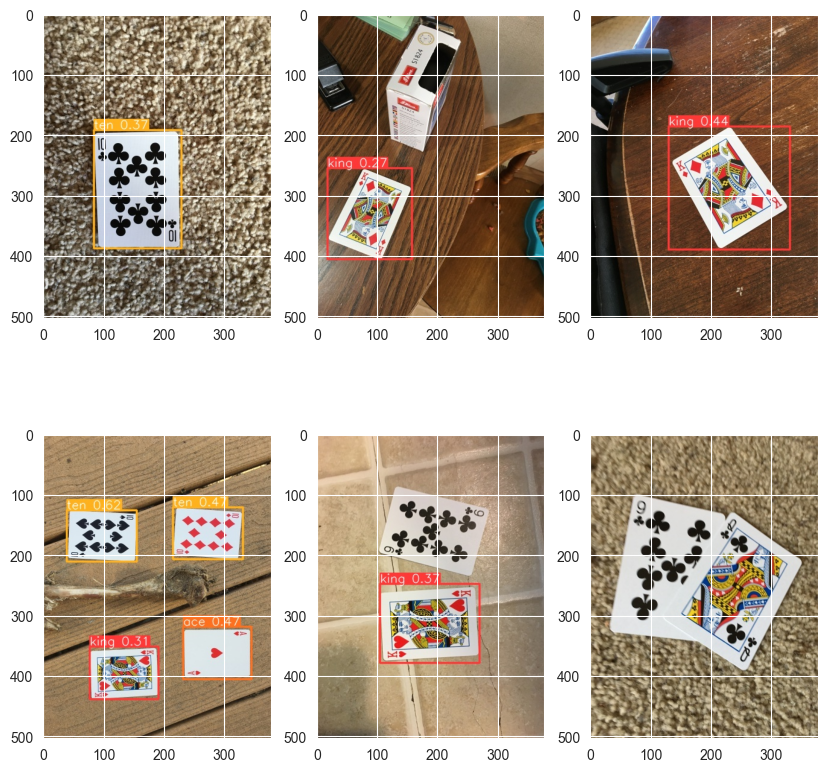

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

detect_paths = [
    './runs/detect/train2/IMG_2395.JPG',
    './runs/detect/train3/IMG_2486.JPG',
    './runs/detect/train4/IMG_2483.JPG',
    './runs/detect/train5/IMG_2558.JPG',
    './runs/detect/train6/IMG_2568.JPG',
    './runs/detect/train7/IMG_2661.JPG'
]

for i, ax in enumerate(axes.reshape(-1)):
    image = Image.open(detect_paths[i])
    ax.imshow(image)

plt.show()